In [ ]:
import numpy as np
from scipy.fft import ifft, fft, fftshift

# Constants
c = 299792458  # Speed of light [m/s]
hbar = 6.62e-34 / (2 * np.pi)  # Planck constant [J/rad]
alpha = 2 * np.pi * 1.00e5  # Cavity loss rate [rad]
Kex = 2 * np.pi * 1.00e5  # Coupling rate [rad]
Kappa = Kex + alpha  # [rad]
tau_photon = (2 * np.pi) / Kappa  # Photon decay time [s]
n2 = 2.2e-20  # Nonlinear RI (silica) [m^2/W]
Pin = 0.400  # Pump power [W]
mode_num = 2**10  # Number of comb modes [-]
f0 = c / 1.5500e-6  # Preset center frequency [Hz]
w0 = 2 * np.pi * f0
fsr = 22e9  # Free spectral range (silica) [Hz]
D1 = 2 * np.pi * fsr

# Frequency domain grid
u = np.arange(-mode_num/2, mode_num/2)  # Grid of mode index mu

# Dispersion
D2 = 2 * np.pi * 17e3  # Dispersion parameter (silica) [rad]
Omega = 0.5 * D2 * u**2

# Nonlinearity
n0 = 1.47  # Refractive index (silica)
Veff = 3e-3 * np.pi * 60e-12  # Effective mode volume
Gamma = hbar * w0**2 * c * n2 / (n0**2 * Veff)

# External source, frequency domain
X = Pin / (hbar * w0)
s_in = np.sqrt(X) * (2 * np.pi * (u == 0))

# Laser tuning time
tau_scan = 3 * tau_photon  # Laser tuning time
Omega_pump = 20 * Kappa  # Initial detuning
v_Detuning = -20 * Kappa / tau_scan
Detuning = -Omega_pump;

# Time grid
N = 12  # [kappa] laser tuning range
stepTime = 1 / fsr
t = np.arange(stepTime, N * tau_scan + stepTime, stepTime)  # Grid of slow time

# Initial field
A_cw = np.sqrt(Kappa / 2) * np.sqrt(Kex * X) * (np.sqrt(Kappa / 2) / Detuning**2 + 1j * np.sqrt(2 / Kappa) / Detuning)
Aw = A_cw * (2 * np.pi * (u == 0)) + 1e-11 * np.random.rand(*u.shape) * np.sqrt(2 * np.pi) * np.exp(1j * 2 * np.pi * np.random.rand(*u.shape))

# Initialize AW with the correct size
nu = len(u)  # Number of modes
n = len(t)  # Total iterations
compression_factor = 100  # Ensure this is consistent with your setup

# Calculate the expected number of stored results
expected_size = n // compression_factor

# Initialize AW with the correct dimensions
AW = np.zeros((nu, expected_size), dtype=complex)

# LLE Solver Function with adjusted indexing
def LLE2(u, t, Aw, Kappa, Omega, Omega_pump, v_Detuning, Gamma, Kex, s_in, compression_factor):
    stepTime = t[1] - t[0]
    nu = len(u)
    dp = 2 * np.pi / nu
    n = len(t)
    AW = np.zeros((nu, n // compression_factor), dtype=complex)
    s_in_t = ifft(fftshift(s_in) / dp)

    for i in range(n):
        # First half-step in time domain
        At = ifft(fftshift(Aw) / dp)
        At *= np.exp((-1j * Gamma * np.abs(At)**2) * stepTime / 2)
        At += stepTime / 2 * np.sqrt(Kex) * s_in_t
        Aw = fftshift(fft(At) * dp)

        # Full step in frequency domain
        Aw *= np.exp((-Kappa / 2 + 1j * (Omega - (Omega_pump + v_Detuning * t[i]))) * stepTime)

        # Second half-step in time domain
        At = ifft(fftshift(Aw) / dp)
        At *= np.exp((-1j * Gamma * np.abs(At)**2) * stepTime / 2)
        At += stepTime / 2 * np.sqrt(Kex) * s_in_t
        Aw = fftshift(fft(At) * dp)

        # Store the result every 'compression_factor' steps
        if i % compression_factor == 0 and i // compression_factor < AW.shape[1]:
            AW[:, i // compression_factor] = Aw

    return AW

# Run the LLE solver
AW1 = LLE2(u, t, Aw, Kappa, Omega, Omega_pump, v_Detuning, Gamma, Kex, s_in, compression_factor)

# Post-processing
E_total = np.array([np.trapz(np.abs(AW1[:, i])**2) for i in range(AW1.shape[1])])

# Plotting (optional)
import matplotlib.pyplot as plt

plt.figure()
plt.subplot(2, 1, 1)
plt.plot(E_total)
plt.title('Total Energy')

plt.subplot(2, 1, 2)
plt.plot(Omega_pump + v_Detuning * t[:len(E_total)])
plt.title('Detuning')

plt.show()

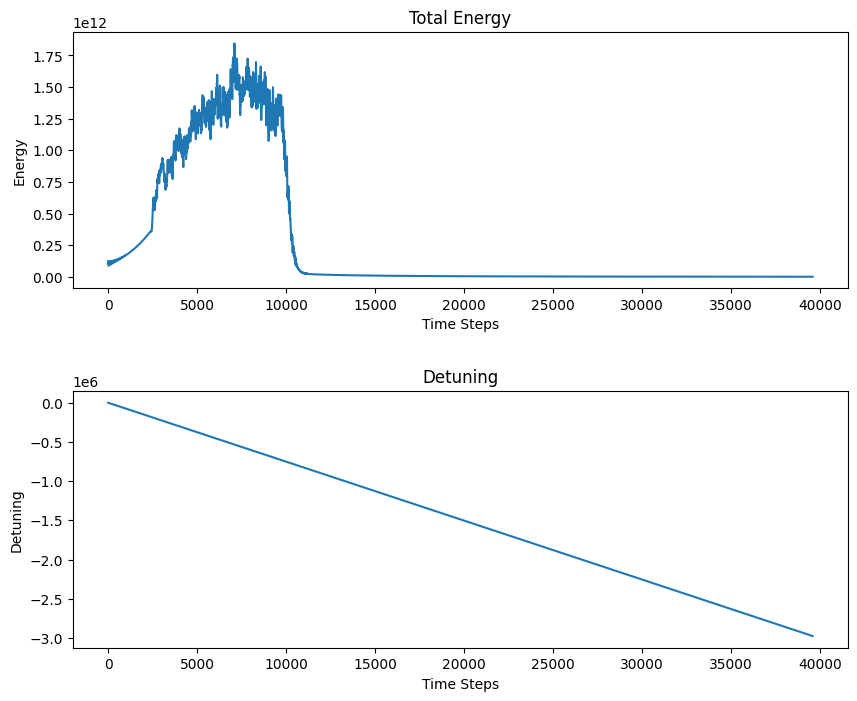

In [14]:
# Determine the minimum length
min_length = min(len(t), len(E_total))

# Truncate t and Omega_pump to the minimum length
t_truncated = t[:min_length]
E_total_truncated = E_total[:min_length]

# Ensure Omega_pump is also truncated or adjusted
Omega_pump_adjusted = Omega_pump[:min_length] + v_Detuning * t_truncated

# Create figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plotting Total Energy
ax1.plot(E_total_truncated)
ax1.set_title('Total Energy')
ax1.set_xlabel('Time Steps')
ax1.set_ylabel('Energy')

# Plotting Detuning
ax2.plot(Omega_pump_adjusted)
ax2.set_title('Detuning')
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('Detuning')

# Adjust spacing
plt.subplots_adjust(hspace=0.4)  # Increase the vertical space between subplots

# Display the plot
plt.show()

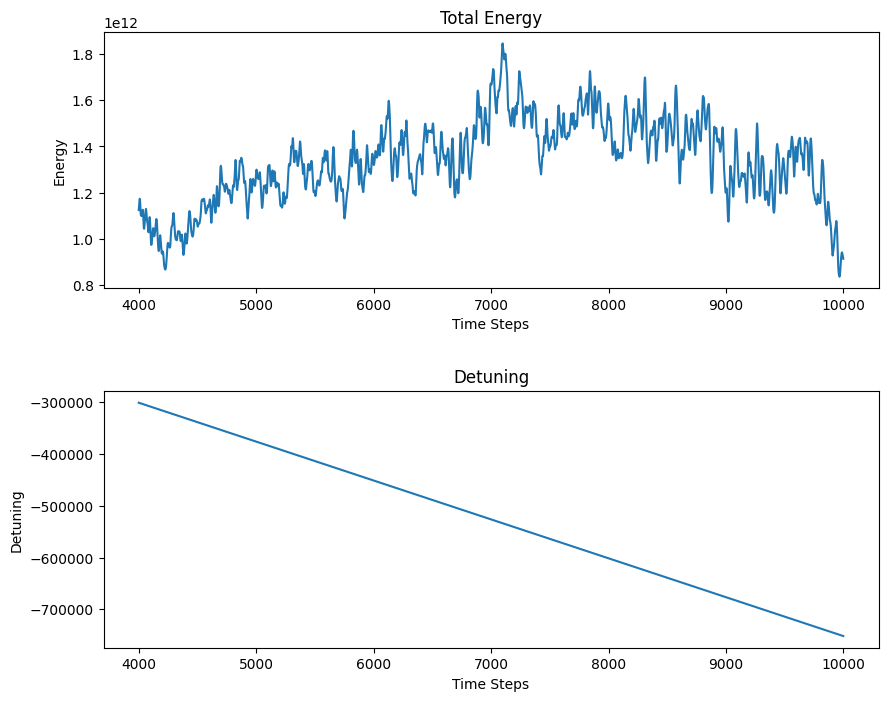

In [26]:
start, end = 4000, 10000

# Slice the data
E_total_focus = E_total[start:end]
Omega_pump_focus = Omega_pump_adjusted[start:end]
time_steps = np.arange(start, end)

# Create figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plotting Total Energy
ax1.plot(time_steps, E_total_focus)
ax1.set_title('Total Energy')
ax1.set_xlabel('Time Steps')
ax1.set_ylabel('Energy')

# Plotting Detuning
ax2.plot(time_steps, Omega_pump_focus)
ax2.set_title('Detuning')
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('Detuning')

# Adjust spacing
plt.subplots_adjust(hspace=0.4)

# Display the plot
plt.show()